In [5]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_msssim import MS_SSIM
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

In [6]:
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = "cpu"
# TODO: make sure to .to(device) the class later, and also set up gpu

# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0
# number of epochs
num_epochs = 25
# batch size for training
batch_size = 16
# height and width of input image
img_size = 64
# the alphabet characters
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
# number of channels
nc0 = 1 * len(alphabet)
nc1 = 4 * len(alphabet)
nc2 = 8 * len(alphabet)
nc3 = 16 * len(alphabet)
# disciminator channels
dc0 = 1
dc1 = 8
dc2 = 16
dc3 = 32
# threshold
thresh = 0
# learning rate
lr = 0.002
# beta1 for Adam
beta1 = 0.5
# real label
real_label = 1.0
# fake label
fake_label = 0.0
# number of extra times to run the discriminator than the encdec per epoch
num_dis = 1
# coefficient of the discriminator loss in training
cof_dis = 7e-3
# number of patches to sample
num_patches = 3
# letter we use to generate all the other letters
base_letter = 'R'
# letter we are trying to generate
gen_letter = 'B'

In [7]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [8]:
class FontDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.fontlist = pd.read_csv(csv_file, sep=' ')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fontlist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {}
        for c in alphabet:
            path = os.path.join(self.root_dir, c, f'{idx}.npy')
            img = np.load(path)
            img = img[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]
            img = self.transform(img)
            sample[c] = img

        return sample

In [9]:
# From https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/3
def get_gaussian_kernel(kernel_size=3, sigma=2, channels=3):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False, padding=1)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    
    return gaussian_filter

In [10]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.conv01 = nn.Conv2d(dc0, dc1, 3, padding=1)
        self.conv12 = nn.Conv2d(dc1, dc2, 3, padding=1)
        self.conv23 = nn.Conv2d(dc2, dc3, 3, padding=1)
#         self.conv24 = nn.Conv2d(dc2, dc4, 3, padding=1)
#         self.conv34 = nn.Conv2d(dc3, dc4, 3, padding=1)
        
        self.conv33 = nn.Conv2d(dc3, dc3, 3, padding=1)
        self.conv32 = nn.Conv2d(dc3, nc0, 3, padding=1)
        
#         self.conv1 = nn.Conv2d(nc0, nc1, 3, padding=1)
        self.conv0same = nn.Conv2d(nc0, nc0, 3, padding=1)
#         self.conv2 = nn.Conv2d(nc1, nc2, 3, padding=1)
#         self.conv3 = nn.Conv2d(nc2, nc2, 3, padding=1)
#         self.conv2back = nn.Conv2d(nc2, nc1, 3, padding=1)
#         self.conv1back = nn.Conv2d(nc1, nc0, 3, padding=1)
        
#         self.conv1strided = nn.Conv2d(nc1, nc1, 3, stride=2, padding=1)
#         self.conv2strided = nn.Conv2d(nc2, nc2, 3, stride=2, padding=1)

#         self.deconv1 = nn.ConvTranspose2d(nc1, nc0, 3, padding=1)
#         self.deconv2 = nn.ConvTranspose2d(nc2, nc1, 3, padding=1)
#         self.deconv1strided = nn.ConvTranspose2d(nc1, nc1, 3, stride=2, padding=1, output_padding=1)
#         self.deconv2strided = nn.ConvTranspose2d(nc2, nc2, 3, stride=2, padding=1, output_padding=1)

#         self.batchnorm0 = nn.BatchNorm2d(nc0)
#         self.batchnorm1 = nn.BatchNorm2d(nc1)
#         self.batchnorm2 = nn.BatchNorm2d(nc2)
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.threshold = nn.Threshold(thresh, 0)
        
        self.gaussian_filter = get_gaussian_kernel(kernel_size = 3, sigma=2, channels=nc0)
        
    def forward(self, x):
        x = self.conv01(x)
        x = self.leakyrelu(x)
        x = self.conv12(x)
        x = self.leakyrelu(x)
        x = self.conv23(x)
        x = self.leakyrelu(x)
        x, idx1 = self.pool(x)
        
        x = self.conv33(x)
        x = self.leakyrelu(x)
        x = self.conv33(x)
        x = self.leakyrelu(x)
        x, idx2 = self.pool(x)
        
        x = self.conv33(x)
        x = self.leakyrelu(x)
        x = self.conv33(x)
        x = self.leakyrelu(x)
        x, idx3 = self.pool(x)
        
        x = self.unpool(x, idx3)
        x = self.conv33(x)
        x = self.leakyrelu(x)
        x = self.conv33(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx2)
        x = self.conv33(x)
        x = self.leakyrelu(x)
        x = self.conv33(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx1)
        x = self.conv32(x)
        x = self.leakyrelu(x)
        
        x = self.gaussian_filter(x)
        x = self.conv0same(x)
        x = self.leakyrelu(x)
        x = self.conv0same(x)
        x = self.leakyrelu(x)
        
        x = self.tanh(x)
        
        return x

In [11]:
class Transformer_EncDec(nn.Module):
    def __init__(self, nhead=8, num_encoder_layers=6):
        model = nn.Transformer(d_model=img_size**2, nhead=nhead, num_encoder_layers=num_encoder_layers)
        
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.float().masked_fill(mask == 1, float('-inf'))
        return mask
    
    def forward(self, src, src_mask):
        trans.torch.ones((1, src.shape[0], img_size*img_size))
        for i in src.shape[0]:
            trans[0][i] = src[i][0].reshape(-1)
        x = model(trans, src_mask)
        
        return model(src, src_mask)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv0 = nn.Conv2d(nc0, nc2, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2stri = nn.Conv2d(nc2, nc2, 4, stride=2, padding=1)
        self.conv2same = nn.Conv2d(nc2, nc2, 3, padding=1)
        self.conv3 = nn.Conv2d(nc2, nc3, 4, stride=2, padding=1)
        self.norm3 = nn.BatchNorm2d(nc3)
        self.conv3same = nn.Conv2d(nc3, nc3, 3, padding=1)
        self.conv3back = nn.Conv2d(nc3, nc2, 3, padding=1)
        self.conv0back = nn.Conv2d(nc2, nc0, 3, padding=1)
        self.flat = nn.Flatten(2)
        self.linear = nn.Linear(img_size//8 * img_size//8, 1)
        self.sigmoid = nn.Sigmoid()
        self.flat1 = nn.Flatten()
        
    def forward(self, input):
        # nc0 x img_size x img_size
        out = self.conv0(input)
        out = self.relu(out)
        
        # nc2 x img_size x img_size
        out = self.conv2stri(out)
        out = self.relu(out)
        
        # nc2 x img_size/2 x img_size/2
        out = self.conv2stri(out)
        out = self.relu(out)
        
        # nc2 x img_size/4 x img_size/4
        out = self.conv2same(out)
        out = self.relu(out)
        out = self.conv2same(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = self.relu(out)
        
        # nc3 x img_size/8 x img_size/8
        out = self.conv3same(out)
        out = self.relu(out)
        out = self.conv3back(out)
        out = self.relu(out)
        
        # nc2 x img_size/8 x img_size/8
        out = self.conv0back(out)
        out = self.relu(out)
        
#         print(out.size())
        out = self.flat(out)
#         print(out.size())
        out = self.linear(out)
#         print(out.size())
        out = self.flat1(out)
        out = self.sigmoid(out)
#         print(out.size())
        
        return out

In [13]:
class LocalDiscriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1 x img_size x img_size
            nn.Conv2d(nc0, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc1),
            nn.ReLU(inplace=True),
            # 4 x img_size/2 x img_size/2
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            # 8 x img_size/4 x img_size/4
            nn.Flatten(),
            nn.Linear(nc2 * img_size // 4 * img_size // 4, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [14]:
def concat_tensors(data):
    tensor = None
    
    for c in alphabet:
        if tensor == None:
            tensor = data[c]
        else:
            tensor = torch.cat((tensor, data[c]), 1)
    
    return tensor

In [15]:
lossD_list = []
loss_disc_list = []
loss_l1_list = []
loss_ssim_list = []
loss_local_list = []
val_set = None

In [16]:
def main():
    dataset = FontDataset(csv_file=fonts_csv, 
                        root_dir=dataroot, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(0.5, 0.5),
#                             AddGaussianNoise(0., 0.05),
                        ]))
    global val_set
    testset_size = len(dataset) // 5 * 4
    train_set, val_set = random_split(dataset, [testset_size, len(dataset) - testset_size], generator=torch.Generator().manual_seed(42))
    
    train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)
    
    encdec = EncoderDecoder()
    # use this line to continue training instead of starting a new one
    # encdec.load_state_dict(torch.load('encdec.pt'))
    
    criterionED_l1 = nn.L1Loss()
    criterionED_ssim = MS_SSIM(win_size=3, data_range=1, size_average=True, channel=nc0)
    optimizerED = optim.Adam(encdec.parameters(), lr=lr)

    disc = Discriminator()
    criterionD = nn.BCELoss()
    optimizerD = optim.Adam(disc.parameters(), lr=lr)
    
    # training loop
    for epoch in range(num_epochs):
        running_lossD = 0.0
        running_loss_disc = 0.0
        running_loss_l1 = 0.0
        running_loss_ssim = 0.0
        running_loss_local = 0.0
        
#         for it in range(num_dis):
#             for i, data in enumerate(train_data):
#                 train_batch = concat_tensors(data)
#                 disc.zero_grad()
                
#                 b_size = train_batch.size(0)
#                 c_size = train_batch.size(1)
#                 label = torch.full((b_size,c_size,), real_label, dtype=torch.float, device=device)
                
#                 outputD = disc(train_batch)
#                 lossD_real = criterionD(outputD, label)
#                 lossD_real.backward()

#                 # all fake batch
#                 outputED = encdec(train_batch)
#                 label.fill_(fake_label)
#                 outputD = disc(outputED.detach())
#                 lossD_fake = criterionD(outputD, label)
#                 lossD_fake.backward()

#                 lossD = lossD_real + lossD_fake
#                 optimizerD.step()
#         print('finished updating dis')
                
        for i, data in enumerate(train_data):
            train_batch = concat_tensors(data)
            ###########################
            # update disc
            ###########################
            disc.zero_grad()
            # all real batch
            b_size = train_batch.size(0)
            c_size = train_batch.size(1)
            label = torch.full((b_size,c_size,), real_label, dtype=torch.float, device=device)
            outputD = disc(train_batch)
            lossD_real = criterionD(outputD, label)
            lossD_real.backward()
            
            # all fake batch
            outputED = encdec(data[base_letter])
            
            label.fill_(fake_label)
            outputD = disc(outputED.detach())
            lossD_fake = criterionD(outputD, label)
            lossD_fake.backward()

            lossD = lossD_real + lossD_fake
            optimizerD.step()

            ###########################
            # update encdec
            ###########################
            encdec.zero_grad()
            # rerun disc
            label.fill_(real_label)
            outputD = disc(outputED)
            lossED_disc = criterionD(outputD, label)
            # run encdec
            lossED_l1 = criterionED_l1(outputED, train_batch)
            
            # calculate local loss
            lossED_local = 0.0
            for _ in range(num_patches):
                x = np.random.randint(16, 48)
                y = np.random.randint(16, 48)
                for j, c in enumerate(alphabet):
                    outputED_patch = outputED[:, j, x-8:x+8, y-8:y+8]
                    datac2_patch = data[c][:, 0, x-8:x+8, y-8:y+8]
                    outputED_patch = (outputED_patch + 1) / 2
                    datac2_patch = (datac2_patch + 1) / 2
                    lossED_local += criterionED_l1(outputED_patch, datac2_patch)
            
            outputED_norm = (outputED + 1) / 2
            train_norm = (train_batch + 1) / 2
            lossED_ssim = 1 - criterionED_ssim(outputED_norm, train_norm)

            lossED = cof_dis * lossED_disc + 0.16 * lossED_l1 + 0.84 * lossED_ssim + lossED_local/num_patches
            lossED.backward()
            optimizerED.step()
    
            running_lossD += lossD.item()
            running_loss_disc += lossED_disc.item()
            running_loss_l1 += lossED_l1.item()
            running_loss_ssim += lossED_ssim.item()
            running_loss_local += lossED_local.item()
            if i % 2 == 0:
                print(f"Epoch {epoch+1}, Iteration {i+1}, Loss D {running_lossD}, Loss Disc {running_loss_disc}, Loss L1 {running_loss_l1}, Loss SSIM {running_loss_ssim}, Loss Local {running_loss_local}")
                lossD_list.append(running_lossD)
                loss_disc_list.append(running_loss_disc)
                loss_l1_list.append(running_loss_l1)
                loss_ssim_list.append(running_loss_ssim)
                loss_local_list.append(running_loss_local)
                running_lossD = 0.0
                running_loss_disc = 0.0
                running_loss_l1 = 0.0
                running_loss_ssim = 0.0
                running_loss_local = 0.0
                
                fig = plt.figure(figsize=(8, 8))
                fig.add_subplot(1, 2, 1)
                plt.imshow(data['A'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                fig.add_subplot(1, 2, 2)
                plt.imshow(outputED[0,0].detach().numpy(), cmap='gray')
                plt.show()
    
#     torch.save(encdec.state_dict(), 'encdec.pt')
    print("Done")

Epoch 1, Iteration 1, Loss D 1.3879276514053345, Loss Disc 0.3583788573741913, Loss L1 0.9856672883033752, Loss SSIM 0.7093597054481506, Loss Local 37.763240814208984


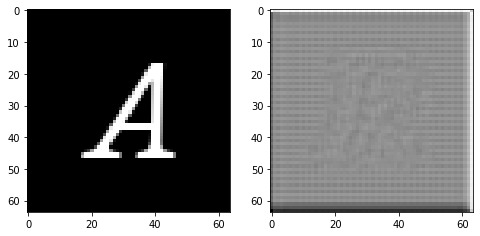

Epoch 1, Iteration 3, Loss D 3.167405128479004, Loss Disc 1.5299367308616638, Loss L1 1.9625284075737, Loss SSIM 1.434573769569397, Loss Local 74.27841186523438


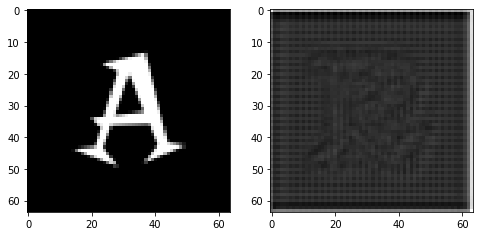

Epoch 1, Iteration 5, Loss D 2.7124661207199097, Loss Disc 1.7230312824249268, Loss L1 1.95182466506958, Loss SSIM 1.4564511179924011, Loss Local 73.43619918823242


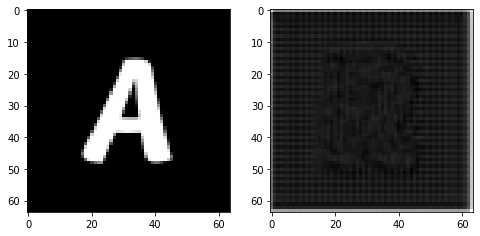

KeyboardInterrupt: 

In [408]:
main()

In [ ]:
# plot losses
plt.plot(loss_ssim_list)
plt.show()

In [17]:
# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0

dataset = FontDataset(csv_file=fonts_csv, 
                      root_dir=dataroot, 
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(0.5, 0.5),
                      ]))

In [20]:
dataloader = DataLoader(val_set, batch_size=1, shuffle=True, num_workers=workers)

encdec = EncoderDecoder()
encdec.load_state_dict(torch.load('encdec.pt'))
encdec.eval()

TypeError: object of type 'NoneType' has no len()

In [19]:
#look at result and ground truth side by side
for i, data in enumerate(dataloader):
    if i > 50:
        break
    fig_letter = 'B'
    fig = plt.figure(figsize=(8, 8))
    output = encdec(data['R'])
    fig.add_subplot(1, 2, 1)
    plt.imshow(data[fig_letter][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(outputED[0,ord(fig_letter) - ord('A')].detach().numpy(), cmap='gray')
    plt.show()

KeyError: 'c1'

<Figure size 576x576 with 0 Axes>

In [21]:
#set up for evaluation
val_data = DataLoader(val_set, batch_size=1, shuffle=True, num_workers=workers)

encdec = EncoderDecoder()
encdec.load_state_dict(torch.load('encdec-Copy1.pt'))
encdec.eval()
criterion_L1 = nn.L1Loss()
criterion_ssim = MS_SSIM(win_size=3, data_range=1, size_average=True, channel=1)

TypeError: object of type 'NoneType' has no len()

In [22]:
#evaluate accuracy using L1 loss
val_len = len(val_data)
sum_L1 = np.zeros((val_len))
sum_ssim = np.zeros((val_len))
for i, data in enumerate(val_data):
    output = encdec(data['R'])
    
    for c in alphabet:
        truth = data[c]
        index = ord(c) - ord('A')
        loss_L1 = criterion_L1(output[0, index], truth)

        output_norm = (output[0, index] + 1) / 2
        truth_norm = (truth+1) / 2
        loss_ssim = 1 - criterion_ssim(output_norm, truth_norm)
        
        sum_L1[index] += loss_L1
        sum_ssim += loss_ssim
    
print(f'{i}, L1: {sum_L1/val_len}, ssim: {sum_ssim/val_len}')

NameError: name 'criterion_L1' is not defined